# TITANIC DATASET
#### INTRO
Sejarah Titanic merupakan salah satu sejarah terkelam. Pada tanggal 15 April 1912, saat pelayaran pertamanya, kapal yang bahkan dijuluki 'Tidak Dapat Ditenggelamkan' menabrak es di Samudra Atlantik dan kemudian karam. Sayangnya, sekoci kapal tak dapat menampung semua penumpang di dalam kapal karena belum ketatnya regulasi pelayaran pada waktu itu mengakibatkan 1502 dari 2224 penumpang dan kru kapal meninggal.

Mungkin ada faktor keberuntungan yang mengakibatkan mereka bisa selamat tapi sepertinya juga ada pola dari grup penumpang-penumpang tersebut sehingga lebih memungkinkan untuk selamat. Pada analisa kali ini kita akan membuat model untuk menjawab pertanyaan: 'Grup penumpang seperti apakah yang lebih memungkinkan untuk selamat?' dengan menggunakan data penumpang seperti (umur, jenis kelamin, kelas sosial-ekonomis, posisi mereka di kapal, dll)
CASE CATEGORY : BINARY CLASSIFIER

#### DATA
Data sudah dipisah menjadi 2 bagian yakni `train.csv` dan `test.csv`. Kemudian ada juga data `gender_submission.csv` untuk mengcrosscheck hasil prediksi model dengan jawaban aktual.
Pada data penumpang terdapat beberapa feature, yakni:
1. PassengerId : Merupakan ID/nomor penanda saja
2. Survived : Ini merupakan target kita, data ini merupakan data biner dimana 1 artinya selamat/survived dan 0 artinya meninggal/tidak survive
3. Pclass : Tolak ukur status ekonomi dan sosial (1 : kelas atas/kaya, 2: kelas menengah, 3: kelas rendah) 
4. Sex : Gender penumpang
5. Name : Nama penumpang
6. Age: umur penumpang
7. SibSp : Jumlah saudara dalam kapal 
8. Parch : jumlah anak/orang tua dalam kapal
9. Ticket : hanyalah nomor unique ticket
10. Fare : Harga tiket
11. Cabin : Nomor kabin penumpang
12. Embarked : Pelabuhan keberangkatan penumpang (C: Cherbourg, Q: Queenstown, S: Southampton)
---

#### IMPORTING DATA AND DATA CLEANING

In [51]:
import pandas as pd

df = pd.read_csv('train_titanic.csv')
df_back = df.copy()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [52]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop data Nama dan tiket karena hal tersebut merupakan data-data unik dan tidak terkategorikan. Untuk data Cabin, penumpang yang tidak memiliki nomor kabin akan di 'flag' sebagai 'Unknown'sehingga model dapat mengambil feature lainnya untuk prediksi. Lebih lanjut lagi data kabin ini akan dipecah menjadi 2 bagian yaitu alphabetnya (mungkin melambangkan tingkat deck?) dan nomor kamarnya.

Nomor kamarnya pun dikategorikan lagi apabila nomor kamarnya berada diantara 1-20 maka di-flag sebagai Zona 1, 21-40 sebagai Zona 2, dst. Pengecualian jika data cabin NaN, maka alphabet cabin akan kita 'flag' sebagai 'U'(Unknown) dan 0 untuk nomor ruangannya (sebagai flag tidak diketahui). Data Umur juga demikian untuk yang NaN kita beri flag -1 untuk memberi tahu sistem mereka semua dalam satu kategori yang sama yang tidak diketahui umurnya.

In [54]:
import re

df['Cabin'] = df['Cabin'].fillna('Unknown')

alphabet_class = []
numeric_class = []

for value in df['Cabin']:
    if value != 'Unknown':
        match = re.search(r"([A-Za-z]+)(\d+)", value)
        if match:
            alphabet_class.append(match.group(1))
            numeric_class.append(int(match.group(2)))
        else:
            match_alpha = re.search(r"[A-Za-z]+", value)
            if match_alpha:
                alphabet_class.append(match_alpha.group(0))
                numeric_class.append(0)
            else:
                alphabet_class.append('U')
                numeric_class.append(0)
    elif value == 'Unknown':
        alphabet_class.append('U')
        numeric_class.append(0)

In [55]:
cabin_number = []
for i in numeric_class:
    if i == 0:
        cabin_number.append(0)
    elif i > 0 and i <= 20:
        cabin_number.append(1)
    elif i > 20 and i <= 40:
        cabin_number.append(2)
    elif i > 40 and i <= 60:
        cabin_number.append(3)
    elif i > 60 and i <= 80:
        cabin_number.append(4)
    elif i > 80 and i <= 100:
        cabin_number.append(5)
    elif i > 100 and i <= 120:
        cabin_number.append(6)
    elif i > 120:
        cabin_number.append(7)

In [56]:
df['AlphaClass'] = alphabet_class
df['NumClass'] = cabin_number

df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
df.drop(columns='Cabin', inplace=True)

In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['AlphaClass'] = le.fit_transform(df['AlphaClass'])
df = pd.get_dummies(df, columns=['Embarked'])

le2 = LabelEncoder()
df['Sex'] = le2.fit_transform(df['Sex'])
df['Age'].fillna(-1, inplace=True)
df

C:\Users\anton\AppData\Local\Temp\ipykernel_12932\1999653302.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(-1, inplace=True)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AlphaClass,NumClass,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,8,0,False,False,True
1,1,1,0,38.0,1,0,71.2833,2,5,True,False,False
2,1,3,0,26.0,0,0,7.9250,8,0,False,False,True
3,1,1,0,35.0,1,0,53.1000,2,7,False,False,True
4,0,3,1,35.0,0,0,8.0500,8,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,8,0,False,False,True
887,1,1,0,19.0,0,0,30.0000,1,3,False,False,True
888,0,3,0,-1.0,1,2,23.4500,8,0,False,False,True
889,1,1,1,26.0,0,0,30.0000,2,7,True,False,False


---
#### EXPLORATORY DATA ANALYSIS

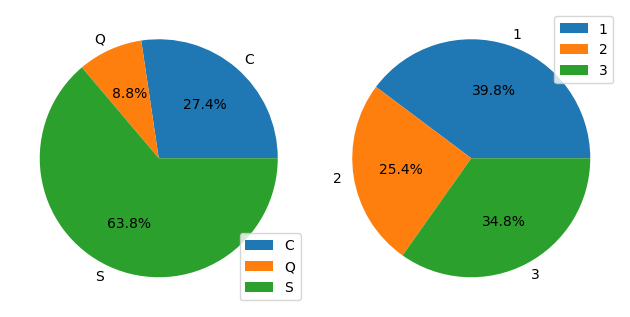

In [58]:
import matplotlib.pyplot as plt

axis_x_emb = df_back.groupby('Embarked')['Survived'].sum()
axis_x_ssc = df_back.groupby('Pclass')['Survived'].sum()

plt.subplot(121)
plt.pie(axis_x_emb.values, labels=axis_x_emb.index, autopct = '%1.1f%%')
plt.legend()

plt.subplot(122)
plt.pie(axis_x_ssc.values, labels=axis_x_ssc.index, autopct = '%1.1f%%')
plt.legend()

plt.tight_layout()
plt.show()

REMARKS: Penumpag yang berangkat dari pelabuhan Southampton lebih banyak yang survive, dan dari segi kelas sosio-ekonomis mereka yang kaya dan (menariknya) kelas rendah lebih banyak yang survive

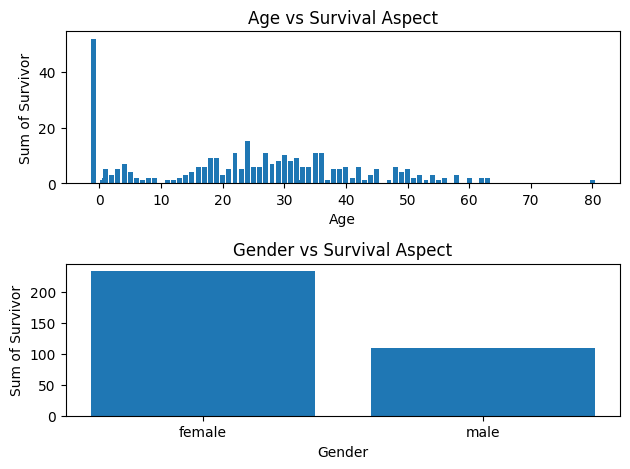

In [59]:
axis_x_age = df.groupby('Age')['Survived'].sum()
axis_x_gdr = df_back.groupby('Sex')['Survived'].sum()

plt.subplot(211)
plt.bar(axis_x_age.index, axis_x_age.values)
plt.xlabel('Age')
plt.ylabel('Sum of Survivor')
plt.title('Age vs Survival Aspect')

plt.subplot(212)
plt.bar(axis_x_gdr.index, axis_x_gdr.values)
plt.xlabel('Gender')
plt.ylabel('Sum of Survivor')
plt.title('Gender vs Survival Aspect')

plt.tight_layout()
plt.show()


REMARKS: Memang penumpang yang selamat lebih banyak tidak diketahui umurnya (ingat tadi diberi flag -1), namun dari overall trend kita bisa melihat bahwa penumpang yang lebih tua (diatas 45 tahun) memiliki survivability rate yang rendah. Dari sini juga kita bisa melihat banyak penumpang wanita yang selamat

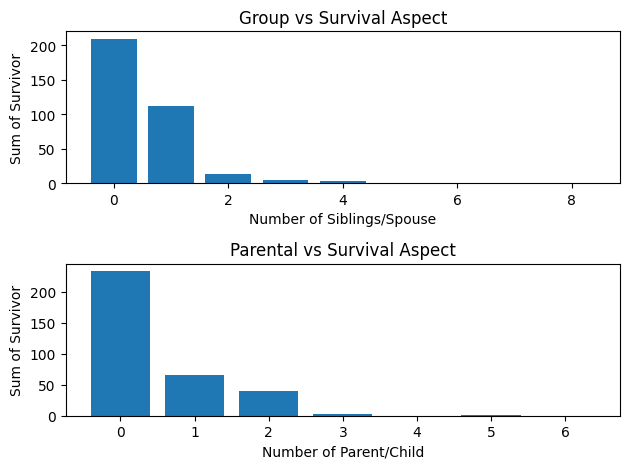

In [60]:
axis_x_sib = df.groupby('SibSp')['Survived'].sum()
axis_x_cp = df.groupby('Parch')['Survived'].sum()

plt.subplot(211)
plt.bar(axis_x_sib.index, axis_x_sib.values)
plt.xlabel('Number of Siblings/Spouse')
plt.ylabel('Sum of Survivor')
plt.title('Group vs Survival Aspect')

plt.subplot(212)
plt.bar(axis_x_cp.index, axis_x_cp.values)
plt.xlabel('Number of Parent/Child')
plt.ylabel('Sum of Survivor')
plt.title('Parental vs Survival Aspect')

plt.tight_layout()
plt.show()


REMARKS: Dari sini terlihat bahwa mereka yang berpergian sendirian memiliki peluang survive yang lebih tinggi

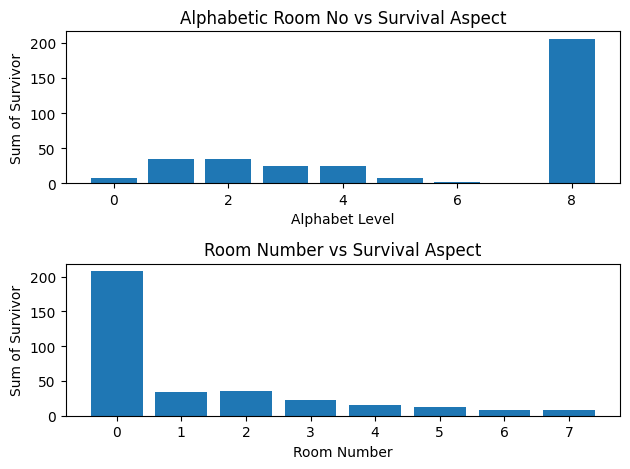

In [61]:
axis_x_ab = df.groupby('AlphaClass')['Survived'].sum()
axis_x_nm = df.groupby('NumClass')['Survived'].sum()

plt.subplot(211)
plt.bar(axis_x_ab.index, axis_x_ab.values)
plt.xlabel('Alphabet Level')
plt.ylabel('Sum of Survivor')
plt.title('Alphabetic Room No vs Survival Aspect')

plt.subplot(212)
plt.bar(axis_x_nm.index, axis_x_nm.values)
plt.xlabel('Room Number')
plt.ylabel('Sum of Survivor')
plt.title('Room Number vs Survival Aspect')

plt.tight_layout()
plt.show()

REMARKS: Lagi-lagi terlihat bahwa penumpang yang tidak teridentifikasi nomor kamar/kabinnya memiliki survivability rate yang tinggi. Namun dilain sisi bisa dilihat juga bahwa mereka yang berada di kompartemen 1 dan 2 (kabin A dan B) dan nomor kamar yang kecil (dibawah 40) memiliki survivability rate yang tinggi

---
#### FEATURE SELECTION AND PREPROCESSING

Berdasarkan hasil EDA di atas terlihat bahwa semua feature memiliki 'group' yang memmpengaruhi survivability penumpang, sehingga kita akan memakai semua feature untuk memprediksi apakah penumpang tsb survive atau tidak. Kita hanya akan menjadikan kolom 'Survived' sebagai target. Rasio training dan test data adalah 80:20 persen.

In [98]:
df.corr()['Survived'].sort_values(ascending=False)

Survived      1.000000
Fare          0.257307
NumClass      0.242904
Embarked_C    0.168240
Parch         0.081629
Age           0.012439
Embarked_Q    0.003650
SibSp        -0.035322
Embarked_S   -0.155660
AlphaClass   -0.302855
Pclass       -0.338481
Sex          -0.543351
Name: Survived, dtype: float64

In [62]:
y = df[['Survived']]
x = df.drop(columns='Survived')

In [63]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

---
### MODELLING MACHINE LEARNING

Pada datasate kali ini kita akan mencoba dan membandingkan 4 model yakni: `SGDClassifier`, `KNeighborsClassifier`, `Random Forest Classifier` dan `GradientBoostingClassifier` untuk melihat performa dari keempat model sebelum ditunning. Kemudian kita akan melakukan tunning dengan bantuan `GridSearchCV` untuk mengoptimalkan hyperparameter dari masing-masing model, dan barulah setelah itu kita seleksi model terbaik untuk tahap selanjutnya.

---

##### Model SGD Classifier

In [64]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(x_train, y_train)

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier()

In [65]:
y_pred = sgd_clf.predict(x_test)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1], dtype=int64)

In [66]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(y_test, y_pred)
acc_score

0.776536312849162

---
##### Model KNeighborsClassifier

In [67]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [68]:
y_pred_knn = knn_clf.predict(x_test)
y_pred_knn

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1], dtype=int64)

In [69]:
acc_score_knn = accuracy_score(y_test, y_pred_knn)
acc_score_knn

0.7039106145251397

---
##### Model RandomForestClassifier

In [70]:
from sklearn.ensemble import RandomForestClassifier

rff_clf = RandomForestClassifier()
rff_clf.fit(x_train, y_train)

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [71]:
y_pred_rff = rff_clf.predict(x_test)
y_pred_rff

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1], dtype=int64)

In [72]:
acc_score = accuracy_score(y_test, y_pred_rff)
acc_score

0.8100558659217877

---

##### Model Gradient Boost Classifier

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt_clf = GradientBoostingClassifier()
gbrt_clf.fit(x_train, y_train)
y_pred_gbrt = gbrt_clf.predict(x_test)
acc_score_gbrt = accuracy_score(y_test, y_pred_gbrt)
acc_score_gbrt

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8044692737430168

---
TUNING KEEMPAT MODEL DENGAN BANTUAN GRID-SEARCH CV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'max_iter': [1000, 5000],
    'learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'tol': [1e-3, 1e-4]
}]

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                           scoring='accuracy',
                           verbose=3,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.001;, score=(train=0.682, test=0.636) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.001;, score=(train=0.638, test=0.622) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.001;, score=(train=0.711, test=0.739) total time=   0.0s
[CV 4/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.001;, score=(train=0.737, test=0.711) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.001;, score=(train=0.642, test=0.634) total time=   0.0s
[CV 1/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.0001;, score=(train=0.754, test=0.797) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=hinge, max_iter=1000, tol=0.0001;, score=(train=0.719, test=0.727) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=hinge, max_it

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.001;, score=(train=0.627, test=0.629) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.001;, score=(train=0.624, test=0.622) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.001;, score=(train=0.551, test=0.620) total time=   0.0s
[CV 4/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.001;, score=(train=0.763, test=0.683) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.001;, score=(train=0.696, test=0.697) total time=   0.0s
[CV 1/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.0001;, score=(train=0.385, test=0.392) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.0001;, score=(train=0.654, test=0.657) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=hinge, max_iter=5000, tol=0.0001;, score=(train=0.393, test=0.387) total ti

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 1/5] END learning_rate=optimal, loss=log_loss, max_iter=1000, tol=0.0001;, score=(train=0.634, test=0.622) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=log_loss, max_iter=1000, tol=0.0001;, score=(train=0.775, test=0.769) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=log_loss, max_iter=1000, tol=0.0001;, score=(train=0.511, test=0.570) total time=   0.0s
[CV 4/5] END learning_rate=optimal, loss=log_loss, max_iter=1000, tol=0.0001;, score=(train=0.668, test=0.627) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=log_loss, max_iter=1000, tol=0.0001;, score=(train=0.630, test=0.577) total time=   0.0s
[CV 1/5] END learning_rate=optimal, loss=log_loss, max_iter=5000, tol=0.001;, score=(train=0.724, test=0.741) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=log_loss, max_iter=5000, tol=0.001;, score=(train=0.643, test=0.622) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=log_loss, max_iter=5000, tol=0.001;, score=(train=0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 4/5] END learning_rate=optimal, loss=log_loss, max_iter=5000, tol=0.0001;, score=(train=0.611, test=0.592) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=log_loss, max_iter=5000, tol=0.0001;, score=(train=0.616, test=0.641) total time=   0.0s
[CV 1/5] END learning_rate=optimal, loss=modified_huber, max_iter=1000, tol=0.001;, score=(train=0.548, test=0.559) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=modified_huber, max_iter=1000, tol=0.001;, score=(train=0.573, test=0.559) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=modified_huber, max_iter=1000, tol=0.001;, score=(train=0.761, test=0.704) total time=   0.0s
[CV 4/5] END learning_rate=optimal, loss=modified_huber, max_iter=1000, tol=0.001;, score=(train=0.781, test=0.746) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=modified_huber, max_iter=1000, tol=0.001;, score=(train=0.596, test=0.563) total time=   0.0s
[CV 1/5] END learning_rate=optimal, loss=modified_huber, max_iter

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 3/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=0.496, test=0.563) total time=   0.0s
[CV 4/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=0.707, test=0.662) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=0.779, test=0.732) total time=   0.0s
[CV 1/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.0001;, score=(train=0.666, test=0.678) total time=   0.0s
[CV 2/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.0001;, score=(train=0.666, test=0.636) total time=   0.0s
[CV 3/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.0001;, score=(train=0.705, test=0.648) total time=   0.0s
[CV 4/5] END learning_rate=optimal, loss=modified_huber, max_iter=5000, tol=0.0001;, score=(train=0.649, test=0.620) total time=   0.0s
[CV 5/5] END learning_rate=optimal, loss=modified_h

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[CV 5/5] END learning_rate=invscaling, loss=modified_huber, max_iter=1000, tol=0.0001;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END learning_rate=invscaling, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END learning_rate=invscaling, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END learning_rate=invscaling, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END learning_rate=invscaling, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END learning_rate=invscaling, loss=modified_huber, max_iter=5000, tol=0.001;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END learning_rate=invscaling, loss=modified_huber, max_iter=5000, tol=0.0001;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END learning_rate=invscaling, loss=modified_huber, 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 930, in fit
    self._mor

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid=[{'learning_rate': ['optimal', 'invscaling',
                                            'adaptive'],
                          'loss': ['hinge', 'log_loss', 'modified_huber'],
                          'max_iter': [1000, 5000], 'tol': [0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [ ]:
print('Grid search optimal for SGDClassifier:')
print(grid_search.best_params_)

Grid search optimal for SGDClassifier:
{'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 5000, 'tol': 0.0001}


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'n_neighbors': [3, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                           scoring='accuracy',
                           verbose=3,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=(train=0.808, test=0.727) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=(train=0.837, test=0.685) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=(train=0.814, test=0.655) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=(train=0.856, test=0.676) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=(train=0.825, test=0.697) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.678) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.690) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.662) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=(train=0.984, test=0.704) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=6, weights=uniform;, score=(train=0.754, test=0.692) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 2/5] END algorithm=auto, n_neighbors=6, weights=uniform;, score=(train=0.766, test=0.664) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=6, weights=uniform;, score=(train=0.746, test=0.669) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=6, weights=uniform;, score=(train=0.760, test=0.655) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=6, weights=uniform;, score=(train=0.737, test=0.697) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=6, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.692) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 3/5] END algorithm=auto, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.704) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=6, weights=distance;, score=(train=0.984, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=7, weights=uniform;, score=(train=0.750, test=0.685) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=7, weights=uniform;, score=(train=0.766, test=0.636) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=7, weights=uniform;, score=(train=0.754, test=0.676) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 4/5] END algorithm=auto, n_neighbors=7, weights=uniform;, score=(train=0.758, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=7, weights=uniform;, score=(train=0.747, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=7, weights=distance;, score=(train=0.982, test=0.692) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.657) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.697) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=7, weights=distance;, score=(train=0.984, test=0.739) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 1/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=0.747, test=0.678) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=0.743, test=0.671) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=0.732, test=0.655) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=0.753, test=0.683) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=auto, n_neighbors=8, weights=uniform;, score=(train=0.730, test=0.683) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=0.982, test=0.678) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.678) total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.704) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.676) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=8, weights=distance;, score=(train=0.984, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=9, weights=uniform;, score=(train=0.749, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=9, weights=uniform;, score=(train=0.749, test=0.657) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 3/5] END algorithm=auto, n_neighbors=9, weights=uniform;, score=(train=0.746, test=0.676) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=9, weights=uniform;, score=(train=0.744, test=0.704) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=9, weights=uniform;, score=(train=0.742, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=9, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.685) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 3/5] END algorithm=auto, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.711) total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.725) total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=9, weights=distance;, score=(train=0.984, test=0.711) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=(train=0.808, test=0.727) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=(train=0.837, test=0.692) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=(train=0.816, test=0.655) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=(train=0.854, test=0.676) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END algorithm=ball_tree, n_neighbors=3, weights=uniform;, score=(train=0.825, test=0.697) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.685) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.690) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.662) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=3, weights=distance;, score=(train=0.984, test=0.704) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=6, weights=uniform;, score=(train=0.754, test=0.692) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 2/5] END algorithm=ball_tree, n_neighbors=6, weights=uniform;, score=(train=0.768, test=0.657) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=6, weights=uniform;, score=(train=0.746, test=0.669) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=6, weights=uniform;, score=(train=0.760, test=0.655) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=ball_tree, n_neighbors=6, weights=uniform;, score=(train=0.737, test=0.697) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=6, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.685) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.704) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.676) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=6, weights=distance;, score=(train=0.984, test=0.718) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END algorithm=ball_tree, n_neighbors=7, weights=uniform;, score=(train=0.750, test=0.685) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=7, weights=uniform;, score=(train=0.766, test=0.636) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=7, weights=uniform;, score=(train=0.754, test=0.676) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 4/5] END algorithm=ball_tree, n_neighbors=7, weights=uniform;, score=(train=0.758, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=7, weights=uniform;, score=(train=0.747, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=7, weights=distance;, score=(train=0.982, test=0.692) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.657) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.697) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.683) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=ball_tree, n_neighbors=7, weights=distance;, score=(train=0.984, test=0.739) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.747, test=0.678) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.743, test=0.671) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.732, test=0.655) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.753, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=8, weights=uniform;, score=(train=0.730, test=0.683) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.982, test=0.678) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 2/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.678) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.704) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.676) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=8, weights=distance;, score=(train=0.984, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=9, weights=uniform;, score=(train=0.745, test=0.713) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END algorithm=ball_tree, n_neighbors=9, weights=uniform;, score=(train=0.749, test=0.657) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=9, weights=uniform;, score=(train=0.747, test=0.676) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=9, weights=uniform;, score=(train=0.746, test=0.711) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=ball_tree, n_neighbors=9, weights=uniform;, score=(train=0.742, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=9, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.685) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.711) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.725) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=9, weights=distance;, score=(train=0.984, test=0.711) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=3, weights=uniform;, score=(train=0.808, test=0.727) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=3, weights=uniform;, score=(train=0.837, test=0.685) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 3/5] END algorithm=kd_tree, n_neighbors=3, weights=uniform;, score=(train=0.814, test=0.655) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=3, weights=uniform;, score=(train=0.856, test=0.676) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=3, weights=uniform;, score=(train=0.825, test=0.697) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.678) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.690) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=(train=0.989, test=0.662) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=kd_tree, n_neighbors=3, weights=distance;, score=(train=0.984, test=0.704) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=(train=0.754, test=0.692) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=(train=0.766, test=0.664) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=(train=0.746, test=0.669) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 4/5] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=(train=0.760, test=0.655) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=(train=0.737, test=0.697) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=6, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.692) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.704) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=6, weights=distance;, score=(train=0.989, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=6, weights=distance;, score=(train=0.984, test=0.718) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 1/5] END algorithm=kd_tree, n_neighbors=7, weights=uniform;, score=(train=0.750, test=0.685) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=7, weights=uniform;, score=(train=0.766, test=0.636) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=7, weights=uniform;, score=(train=0.754, test=0.676) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=7, weights=uniform;, score=(train=0.758, test=0.683) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=kd_tree, n_neighbors=7, weights=uniform;, score=(train=0.747, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=7, weights=distance;, score=(train=0.982, test=0.692) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.657) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.697) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=7, weights=distance;, score=(train=0.989, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=7, weights=distance;, score=(train=0.984, test=0.739) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.747, test=0.678) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.743, test=0.671) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 3/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.732, test=0.655) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.753, test=0.683) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=8, weights=uniform;, score=(train=0.730, test=0.683) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.982, test=0.678) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.678) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.704) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.989, test=0.676) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 5/5] END algorithm=kd_tree, n_neighbors=8, weights=distance;, score=(train=0.984, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=9, weights=uniform;, score=(train=0.749, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=9, weights=uniform;, score=(train=0.749, test=0.657) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=9, weights=uniform;, score=(train=0.746, test=0.676) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 4/5] END algorithm=kd_tree, n_neighbors=9, weights=uniform;, score=(train=0.744, test=0.704) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=9, weights=uniform;, score=(train=0.742, test=0.718) total time=   0.0s
[CV 1/5] END algorithm=kd_tree, n_neighbors=9, weights=distance;, score=(train=0.982, test=0.713) total time=   0.0s
[CV 2/5] END algorithm=kd_tree, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.685) total time=   0.0s
[CV 3/5] END algorithm=kd_tree, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.711) total time=   0.0s
[CV 4/5] END algorithm=kd_tree, n_neighbors=9, weights=distance;, score=(train=0.989, test=0.725) total time=   0.0s
[CV 5/5] END algorithm=kd_tree, n_neighbors=9, weights=distance;, score=(train=0.984, test=0.711) total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                          'n_neighbors': [3, 6, 7, 8, 9],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [ ]:
print('Grid search optimal for KNNClassifier:')
print(grid_search.best_params_)

Grid search optimal for KNNClassifier:
{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}


In [ ]:
param_grid = [{
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'ccp_alpha': [0, 0.05, 0.1]
}]

grid_search = GridSearchCV(rff_clf, param_grid, cv=5,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'ccp_alpha': [0, 0.05, 0.1],
                          'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [3, 5, 10, None],
                          'max_features': ['sqrt', 'log2', None],
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
print('Grid search optimal for RandomForestClassifier:')
print(grid_search.best_params_)

Grid search optimal for RandomForestClassifier:
{'bootstrap': True, 'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [ ]:
param_grid = [{
    'loss': ['exponential', 'log_loss'],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 5, 10, None],
    'criterion': ['friedman_mse', 'squared_error']
}]

grid_search = GridSearchCV(gbrt_clf, param_grid, cv=5,
                           scoring='accuracy',
                           verbose=2,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, loss=log_loss, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid=[{'criterion': ['friedman_mse', 'squared_error'],
                          'loss': ['exponential', 'log_loss'],
                          'max_depth': [3, 5, 10, None],
                          'max_features': ['sqrt', 'log2', None],
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [50, 100, 150, 200]}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [ ]:
print('Grid search optimal for GBRT:')
print(grid_search.best_params_)

Grid search optimal for GBRT:
{'criterion': 'friedman_mse', 'loss': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


---

##### MASUKAN HYPERPARAMETER YANG SUDAH DICARI DENGAN MENGGUNAKAN GRID-SEARCH CV KE DALAM MASING-MASING MODEL

In [74]:
sgd_clf_opt = SGDClassifier(learning_rate='optimal', loss='log_loss',
                            max_iter=5000, tol= 0.0001)
sgd_clf_opt.fit(x_train, y_train)
y_pred_sgd_opt = sgd_clf_opt.predict(x_test)
acc_score_sgd = accuracy_score(y_test, y_pred_sgd_opt)
acc_score_sgd

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7486033519553073

In [75]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf_opt = KNeighborsClassifier(algorithm='auto', n_neighbors=9,
                               weights='distance')
knn_clf_opt.fit(x_train, y_train)
y_pred_knn_opt = knn_clf_opt.predict(x_test)
acc_score_knn = accuracy_score(y_test, y_pred_knn_opt)
acc_score_knn

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7150837988826816

In [76]:
from sklearn.ensemble import RandomForestClassifier

rff_clf_opt = RandomForestClassifier(n_estimators=200, ccp_alpha=0, criterion='entropy',
                                     max_depth=10, max_features=None,
                                     min_samples_leaf=1, min_samples_split=5)
rff_clf_opt.fit(x_train, y_train)
y_pred_rff_opt = rff_clf_opt.predict(x_test)
acc_score_rff = accuracy_score(y_test, y_pred_rff_opt)
acc_score_rff


c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8268156424581006

In [77]:
gbrt_clf_opt = GradientBoostingClassifier(criterion='friedman_mse', loss='log_loss',
                                          max_depth=5, max_features='sqrt',
                                          min_samples_leaf=4, min_samples_split=10,
                                          n_estimators=100)
gbrt_clf_opt.fit(x_train, y_train)
y_pred_gbrt_opt = gbrt_clf_opt.predict(x_test)
acc_score_gbrt_opt = accuracy_score(y_test, y_pred_gbrt_opt)
acc_score_gbrt_opt

c:\Programming\.vscode\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8212290502793296

---
### APPLY IT TO TEST CASE

Dari hasil seleksi diatas kita akan mencoba 2 model yakni `RandomForestClassifier` dan `GradientBoostingCLassifier` untuk mencoba memprediksi test case dalam file 'test_titanic.csv'. Pada file csv ini kita akan tetap melkukan cleaning data terlebih dahulu sehingga fromat dan featurenya sama dengan data training diatas.

In [78]:
test = pd.read_csv('test_titanic.csv')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [79]:
test['Cabin'] = test['Cabin'].fillna('Unknown')

alphabet_class = []
numeric_class = []

for value in test['Cabin']:
    if value != 'Unknown':
        match = re.search(r"([A-Za-z]+)(\d+)", value)
        if match:
            alphabet_class.append(match.group(1))
            numeric_class.append(int(match.group(2)))
        else:
            match_alpha = re.search(r"[A-Za-z]+", value)
            if match_alpha:
                alphabet_class.append(match_alpha.group(0))
                numeric_class.append(0)
            else:
                alphabet_class.append('U')
                numeric_class.append(0)
    elif value == 'Unknown':
        alphabet_class.append('U')
        numeric_class.append(0)

cabin_number = []
for i in numeric_class:
    if i == 0:
        cabin_number.append(0)
    elif i > 0 and i <= 20:
        cabin_number.append(1)
    elif i > 20 and i <= 40:
        cabin_number.append(2)
    elif i > 40 and i <= 60:
        cabin_number.append(3)
    elif i > 60 and i <= 80:
        cabin_number.append(4)
    elif i > 80 and i <= 100:
        cabin_number.append(5)
    elif i > 100 and i <= 120:
        cabin_number.append(6)
    elif i > 120:
        cabin_number.append(7)

In [80]:
test['AlphaClass'] = alphabet_class
test['NumClass'] = cabin_number

test.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
test.drop(columns='Cabin', inplace=True)

In [81]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test['AlphaClass'] = le.fit_transform(test['AlphaClass'])
test = pd.get_dummies(test, columns=['Embarked'])

le2 = LabelEncoder()
test['Sex'] = le2.fit_transform(test['Sex'])

test['Age'].fillna(-1, inplace=True)
test

C:\Users\anton\AppData\Local\Temp\ipykernel_12932\1565969368.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Age'].fillna(-1, inplace=True)


,Pclass,Sex,Age,SibSp,Parch,Fare,AlphaClass,NumClass,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.5,0,0,7.8292,7,0,False,True,False
1,3,0,47.0,1,0,7.0000,7,0,False,False,True
2,2,1,62.0,0,0,9.6875,7,0,False,True,False
3,3,1,27.0,0,0,8.6625,7,0,False,False,True
4,3,0,22.0,1,1,12.2875,7,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,-1.0,0,0,8.0500,7,0,False,False,True
414,1,0,39.0,0,0,108.9000,2,6,True,False,False
415,3,1,38.5,0,0,7.2500,7,0,False,False,True
416,3,1,-1.0,0,0,8.0500,7,0,False,False,True


In [82]:
#Ternyata ada data NaN pada test case di Fare, karena cuman satu saja, kita akan drop data ini

nan_indices = test[test.isna().any(axis=1)].index
test.iloc[nan_indices]

,Pclass,Sex,Age,SibSp,Parch,Fare,AlphaClass,NumClass,Embarked_C,Embarked_Q,Embarked_S
152,3,1,60.5,0,0,NaN,7,0,False,False,True


In [83]:
test.dropna(inplace=True)

#### PREDIKSI DATA TEST CASE DENGAN `RandomForestClassifier` DAN `GradientBoostingClassifier`

In [84]:
y_pred_rff_testcase = rff_clf_opt.predict(test)
y_pred_rff_testcase

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

In [85]:
y_pred_gbrt_testcase = gbrt_clf_opt.predict(test)
y_pred_gbrt_testcase

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,

---
### CROSSCHECK PREDICTION ANSWER WITH REAL ANSWER

Dari data prediksi kedua model diatas, kita aan bandingkan dengan kunci jawabannya dan kita akan menilai model manakah yang terbaik untuk kasus ini berdasarkan tingkat presisi, recall, f1_score, akurasi serta melihat hasil confussion matrix 

In [86]:
check = pd.read_csv('gender_submission.csv')
check

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [87]:
check.drop(index=152, inplace=True)

In [88]:
check.drop(columns='PassengerId', inplace=True)

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

validation_score_rff_acc = accuracy_score(check, y_pred_rff_testcase)
validation_score_rff_ps = precision_score(check, y_pred_rff_testcase)
validation_score_rff_rc = recall_score(check, y_pred_rff_testcase)
validation_score_rff_f1 = f1_score(check, y_pred_rff_testcase)

print(f'Accuracy score: {validation_score_rff_acc}')
print(f'Precision score: {validation_score_rff_ps}')
print(f'Recall score: {validation_score_rff_rc}')
print(f'F1 score: {validation_score_rff_f1}')

Accuracy score: 0.8705035971223022
Precision score: 0.8450704225352113
Recall score: 0.7894736842105263
F1 score: 0.8163265306122449


In [92]:
conf_matrix_rff = confusion_matrix(check, y_pred_rff_testcase)
conf_matrix_rff

array([[243,  22],
       [ 32, 120]], dtype=int64)

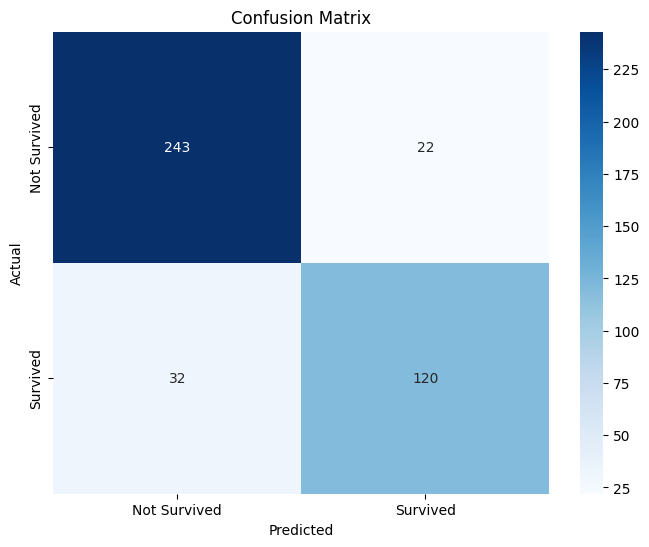

In [94]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rff, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [90]:
validation_score_gbrt_acc = accuracy_score(check, y_pred_gbrt_testcase)
validation_score_gbrt_ps = precision_score(check, y_pred_gbrt_testcase)
validation_score_gbrt_rc = recall_score(check, y_pred_gbrt_testcase)
validation_score_gbrt_f1 = f1_score(check, y_pred_gbrt_testcase)

print(f'Accuracy score: {validation_score_gbrt_acc}')
print(f'Precision score: {validation_score_gbrt_ps}')
print(f'Recall score: {validation_score_gbrt_rc}')
print(f'F1 score: {validation_score_gbrt_f1}')

Accuracy score: 0.8393285371702638
Precision score: 0.8148148148148148
Recall score: 0.7236842105263158
F1 score: 0.7665505226480837


In [93]:
conf_matrix_gbrt = confusion_matrix(check, y_pred_gbrt_testcase)
conf_matrix_gbrt

array([[240,  25],
       [ 42, 110]], dtype=int64)

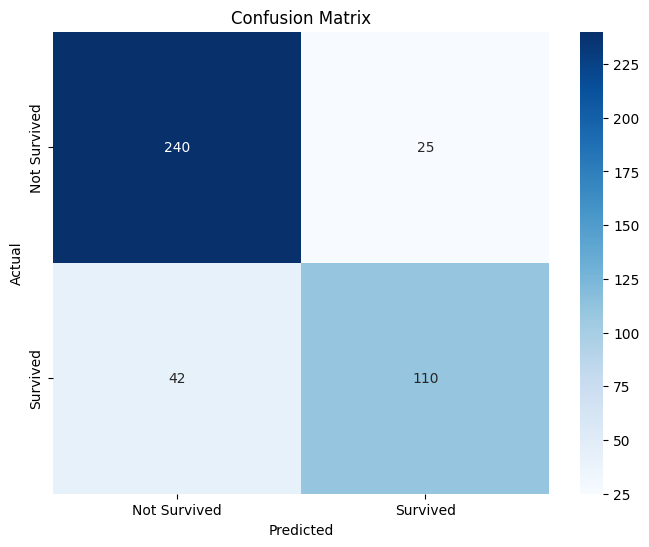

In [95]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbrt, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---
##### KESIMPULAN
 Berdasarkan hasil analisa diatas ternyata tingkat keselamatan penumpang bukanlah hanya keberuntungan semata. Status penumpang seperti umur, gender, level ekonomi-sosial memiliki dampak terhadap survivability rate penumpang. Tidak hanya itu, kita juga bisa melihat bahwa travelling behavior penumpang (travelling solo atau group) serta posisi tinggal penumpang dalam kapal memiliki dampak terhadap tinggak keselamatan dirinya.

 Spesifiknya berikut adalah penumpang-penumpang yang memiliki peluang selamat besar:
 1. Mereka yang berpergian sendirian tanpa grup
 2. Merupakan Gender wanita
 3. Berumur tidak lebih dari 45 tahun
 4. Tinggal di kompartemen A dan B serta berada di kamar-kamar yang memiliki nomor rendah
 5. Berasal dari status ekonomi yang kaya atau menengah ke bawah.

 Kemudian dengan menggunakan Machine Learning, kita bisa membuat sebuah model yang bisa memprediksi apakah penumpang tersebut selamat atau tidak. Dalam kasus ini 2 model (yakni `RandomForestClassifier` dan `GradientBoostingClassifier`) memiliki performa terbaik dari 2 lainnya (`SGDClassifier` dan `KNeighborsClassifier`), masing-masing dengan nilai akurasi.


##### TO-DO LIST:
1. Explorasi lagi dengan Feature Engineering data-data NaN diatas, misalnya untuk umur diprediksi dengan mean(), ffil() dll namun dibuat kolom baru yang diberi flag 'Not-Labeled' untuk memberitahu komputer walaupun data NaN sudah diisi dengan data tapi tetap masuk kategori tidak ada label, apakah akan memberikan dampak signifikan untuk menaikan nilai akurasi model.
2. Coba gunakan XGBoost model, apakah lebih baik dari semuanya.
3. Bisakah kita meningkatkan performa model SGDClassifier dan KNeighborsClassifier dengan menggabungkannya memakai teknik ensemble Bagging-and-Pasting